<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

**and generally anything you deem can be modified without having to undergo major construction on the house.**

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

## Q1. <span style="color:Teal"> Approach </span>

- Quick overview scan of dataset
- Drop non residential (MSzoning: I, C & A)
- Examine the dataset and check for incomplete/unclean data (NaN is not necessarily a problem for some columns columns)
- Clean up any discrepancies, feature engineering
- Identify 'Fixed' features with reference from data dictionary (factors that cannot be renovated on)
- Split data & run model accordingly: Train 'YrSold' = pre-2010 & Test 'YrSold' = post-2010 
- Feature Scaling: Run scale on train dataset
- Create Dummy Variables
- Analyze the model and performance
- Rank the coefficients

In [3]:
# A:
house.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
905,906,20,RL,80.0,9920,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,128000
1183,1184,30,RL,60.0,10800,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,120000
1153,1154,30,RM,NaN,5890,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,120500
576,577,50,RL,52.0,6292,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,145000
190,191,70,RL,70.0,10570,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,12,2007,WD,Normal,315000


### Dropping non-residential properties to zoom into relevant market

In [4]:
# Checking
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [5]:
# Dropping
house.drop(house.index[house['MSZoning']=='C (all)'],inplace=True)
house.MSZoning.value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

### Examining Residential Dataset ( & Cleaning while at it...)

In [6]:
house.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1450.000000,1450.000000,1191.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1442.000000,1450.000000,...,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,731.364138,56.903448,70.052897,10523.831724,6.114483,5.582069,1971.593103,1985.049655,104.404300,445.162759,...,94.826897,46.537931,21.536552,3.433103,15.096552,2.777931,43.365517,6.312414,2007.812414,181654.942069
std,421.554345,42.265033,24.301013,10012.185355,1.372860,1.107330,30.022696,20.552319,181.486539,456.353871,...,125.560863,65.222761,60.838826,29.416948,55.893399,40.315051,497.636495,2.698244,1.326321,79176.485241
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000
25%,366.250000,20.000000,59.000000,7544.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,731.500000,50.000000,70.000000,9496.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,384.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163945.000000
75%,1096.750000,70.000000,80.000000,11613.500000,7.000000,6.000000,2001.000000,2004.000000,166.750000,713.750000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
# Using this to scan for questionable columns
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-n

In [8]:
# Only 1 property doesn't have all utilities
house[house['Utilities']=='NoSeWa']

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
944,945,20,RL,NaN,14375,Pave,NaN,IR1,Lvl,NoSeWa,...,0,NaN,NaN,NaN,0,1,2009,COD,Abnorml,137500


In [9]:
# These are the columns that need looking into
house.columns[house.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

#### Lots of Frontage, Not
If there isn't any frontage, then set the area to 0

In [10]:
house.LotFrontage.fillna(0, inplace=True)

#### Alley - Oops?
If there isn't any alley access, set value to No Alley (so that we can track dummy column later)

In [11]:
# 89 houses with Alley in two material types. The rest of the properties do not have an alley access.
house.Alley.value_counts()

Grvl    50
Pave    39
Name: Alley, dtype: int64

In [12]:
house.Alley.fillna(value="No Alley",inplace=True)
house.Alley.value_counts()

No Alley    1361
Grvl          50
Pave          39
Name: Alley, dtype: int64

#### Freemason is in the building

Convert Null to None and Area to 0

In [13]:
# 8 Units needs to convert Masonry Veneer Type to None & Change the MasVnrArea to 0
house[house.MasVnrType.isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
234,235,60,RL,0.0,7851,Pave,No Alley,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,216500
529,530,20,RL,0.0,32668,Pave,No Alley,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Alloca,200624
650,651,60,FV,65.0,8125,Pave,No Alley,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,205950
936,937,20,RL,67.0,10083,Pave,No Alley,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,184900
973,974,20,FV,95.0,11639,Pave,No Alley,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,New,Partial,182000
977,978,120,FV,35.0,4274,Pave,Pave,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,New,Partial,199900
1243,1244,20,RL,107.0,13891,Pave,No Alley,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,New,Partial,465000
1278,1279,60,RL,75.0,9473,Pave,No Alley,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2008,WD,Normal,237000


In [14]:
house.MasVnrType.fillna('None',inplace=True)
house.MasVnrType.value_counts()

None       862
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [15]:
house.MasVnrArea.fillna(0,inplace=True)

#### Basement Jaxx
 Reclassifying into No basement and hence No Basement Condition  
 Look into Exposure and finishtypes to reclass the nulls  
 *By right, I should be checking to verify the ones with Null values are coming from properties with 'No Basement'

In [16]:
# 37 null units has No basement
house.BsmtQual.value_counts()

TA    639
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [17]:
house.BsmtQual.fillna('No Basement',inplace=True)
house.BsmtQual.value_counts()

TA             639
Gd             618
Ex             121
No Basement     37
Fa              35
Name: BsmtQual, dtype: int64

In [18]:
house.BsmtCond.value_counts()

TA    1303
Gd      65
Fa      43
Po       2
Name: BsmtCond, dtype: int64

In [19]:
house.BsmtCond.fillna('No Bsmt Cond',inplace=True)
house.BsmtCond.value_counts()

TA              1303
Gd                65
Fa                43
No Bsmt Cond      37
Po                 2
Name: BsmtCond, dtype: int64

In [20]:
house.BsmtExposure.fillna('No Bsmt Expo',inplace=True)
house.BsmtExposure.value_counts()

No              947
Av              219
Gd              134
Mn              112
No Bsmt Expo     38
Name: BsmtExposure, dtype: int64

In [21]:
house.BsmtFinType1.fillna('No Bsmt Fin',inplace=True)
house.BsmtFinType1.value_counts()

Unf            424
GLQ            418
ALQ            220
BLQ            147
Rec            130
LwQ             74
No Bsmt Fin     37
Name: BsmtFinType1, dtype: int64

In [22]:
house.BsmtFinType2.fillna('No Bsmt Fin',inplace=True)
house.BsmtFinType2.value_counts()

Unf            1246
Rec              54
LwQ              46
No Bsmt Fin      38
BLQ              33
ALQ              19
GLQ              14
Name: BsmtFinType2, dtype: int64

#### Elec-trick-al
Since Utilities rated this lone unit as 'AllPub', there should be an electrical system in place.  
Most properties use a Standard Breaker unit, we shall allocate that to this property.

In [23]:
house[house.Electrical.isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,No Alley,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500


In [24]:
house.Electrical.fillna('SBrkr',inplace=True)
house.Electrical.value_counts()

SBrkr    1329
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

#### Fighting fire with fire
There are 681 null values for fireplace quality and it matches incidences of Fireplace = 0.  
This means the null values are explained by properties without fireplaces.  
We shall replace null with No Fireplace to Qualify

In [25]:
house[(house['FireplaceQu'].isnull()) & (house['Fireplaces']==0)].shape

(681, 81)

In [26]:
house.FireplaceQu.fillna('No Fire Qual',inplace=True)
house.FireplaceQu.value_counts()

No Fire Qual    681
Gd              379
TA              313
Fa               33
Ex               24
Po               20
Name: FireplaceQu, dtype: int64

#### Garage-Banding

Seems like there are 79 properties without garages and that has downstream implications on the garage columns  

- **I will not touch Year built for now as I would want to convert it to age at point of sale before adding 0 to the null values**

GarageType       1371 non-null object  
GarageYrBlt      1371 non-null float64  
GarageFinish     1371 non-null object  
GarageCars       1450 non-null int64  
GarageArea       1450 non-null int64  
GarageQual       1371 non-null object  
GarageCond       1371 non-null object  

In [27]:
house[(house['GarageType'].isnull()) & (house['GarageArea']==0)].shape

(79, 81)

In [28]:
house.GarageType.fillna('No GarType',inplace=True)
house.GarageType.value_counts()

Attchd        870
Detchd        381
BuiltIn        88
No GarType     79
Basment        18
CarPort         8
2Types          6
Name: GarageType, dtype: int64

In [29]:
house.GarageFinish.fillna('No GarFin',inplace=True)
house.GarageFinish.value_counts()

Unf          600
RFn          419
Fin          352
No GarFin     79
Name: GarageFinish, dtype: int64

In [30]:
house.GarageQual.fillna('No GarQual',inplace=True)
house.GarageQual.value_counts()

TA            1303
No GarQual      79
Fa              48
Gd              14
Po               3
Ex               3
Name: GarageQual, dtype: int64

In [31]:
house.GarageCond.fillna('No GarCond',inplace=True)
house.GarageCond.value_counts()

TA            1319
No GarCond      79
Fa              34
Gd               9
Po               7
Ex               2
Name: GarageCond, dtype: int64

#### Pooling it together

In [32]:
house.PoolQC.fillna('No Pool',inplace=True)
house.PoolQC.value_counts()

No Pool    1443
Gd            3
Fa            2
Ex            2
Name: PoolQC, dtype: int64

#### In my de-fence

In [33]:
house.Fence.fillna('No Fence',inplace=True)
house.Fence.value_counts()

No Fence    1172
MnPrv        155
GdPrv         59
GdWo          53
MnWw          11
Name: Fence, dtype: int64

#### Miscellany Blahblah


In [34]:
house.MiscFeature.value_counts()

Shed    47
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [35]:
house.MiscFeature.fillna('Featureless',inplace=True)
house.MiscFeature.value_counts()

Featureless    1398
Shed             47
Gar2              2
Othr              2
TenC              1
Name: MiscFeature, dtype: int64

### Feature Engineering

- Barring heritage conservation efforts, we would assume the younger the properties, the better prices it may fetch
- Swapping years built/ remodelled/ garage built to age at point of sale

In [36]:
house[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']].describe(include='all')

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,1450.000000,1450.000000,1371.000000,1450.000000
mean,1971.593103,1985.049655,1978.627279,2007.812414
std,30.022696,20.552319,24.592779,1.326321
min,1872.000000,1950.000000,1906.000000,2006.000000
25%,1954.000000,1967.000000,1961.500000,2007.000000
50%,1973.000000,1994.000000,1980.000000,2008.000000
75%,2001.000000,2004.000000,2002.000000,2009.000000
max,2010.000000,2010.000000,2010.000000,2010.000000


In [37]:
house[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']].sample(5)

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
901,1957,2000,1968.0,2009
1150,1950,1950,1950.0,2007
726,1988,2007,1988.0,2009
530,1988,1989,1988.0,2008
735,1914,1970,1914.0,2006


In [38]:
house['Actual Property Age'] = house.apply(lambda row: row.YrSold - row.YearBuilt, axis=1 )

In [39]:
house['Refreshed Age'] = house.apply(lambda row: row.YrSold - row.YearRemodAdd, axis=1)

In [40]:
house['Garage Age'] = house.apply(lambda row: row.YrSold - row.GarageYrBlt,axis =1)

In [41]:
house[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','Actual Property Age','Garage Age','Refreshed Age']].head(5)

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,Actual Property Age,Garage Age,Refreshed Age
0,2003,2003,2003.0,2008,5,5.0,5
1,1976,1976,1976.0,2007,31,31.0,31
2,2001,2002,2001.0,2008,7,7.0,6
3,1915,1970,1998.0,2006,91,8.0,36
4,2000,2000,2000.0,2008,8,8.0,8


#### Cleaning up gar-age
- Seems like i need to impute numerical value. 
- I will set age of garage to age of last remod in the case of null value

In [42]:
house['Garage Age'] = house.apply(lambda row: row['Refreshed Age'] if np.isnan(row['Garage Age']) else row['Garage Age'], axis=1)

In [43]:
house[['YrSold','Actual Property Age','Garage Age','Refreshed Age']].sample(5)

,YrSold,Actual Property Age,Garage Age,Refreshed Age
1179,2006,52,52.0,52
595,2006,1,1.0,0
961,2008,31,31.0,13
209,2008,44,44.0,44
92,2009,88,88.0,3


#### Dropping it like its hot - Part 1
- Dropping GarageYrBlt, YearBuilt, YearRemodAdd

In [44]:
house.drop(['GarageYrBlt','YearBuilt','YearRemodAdd'],axis=1,inplace=True)

In [45]:
house.columns[house.isnull().any()]

Index([], dtype='object')

## Separating property characteristics

- Some qualities of a property cannot be changed even with renovation works: structural,plot,neighbourhood
- Some features might be considered 'fixed' as they might be constrained by the area (e.g adding a swimming pool) or requires massive overhauling of the property (e.g creating a basement) or just historical records
-----------------------------------  
- MSSubClass to HouseStyle -> fixed
- OverallQUality to ExteriorCond -> Generally can be modified/improved on with some work (sans hacking)
- Masonry veneer is a non structural feature, i would classify it as nonfixed
- Foundation + BsmtQUality + BsmtExposure + TotalBsmtSF -> Fixed, prebuilt structural items
- BsmtCOnd, BsmtFinType1/2 ,BsmtFinSF1/2 to Electrical + LowQualFinSF -> Renovate-able features
- 1stFlrSF to Kitchen + TotalRmsAbvGrd + GarageType, GarageArea, GarageCar, #Fireplace-> Fixed features tied to structural/plot
- FireplaceQuality, GarageFin, GarageQual,GarageCond,PavedDrive to Fence -> Can be worked on if available
- Misc -> Fixed features tied to plotsize
------------------------------------
- Transaction and sales condition stats: Age, Functional, SaleType, SaleCond, Price, MiscVal

In [46]:
len(house.columns)

81

In [47]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPor

In [48]:
fixedcharlist = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle','Foundation', 'BsmtQual', 'BsmtExposure',
       'TotalBsmtSF','1stFlrSF', '2ndFlrSF','GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces','GarageType', 'GarageCars', 'GarageArea',
       'PoolArea','MiscFeature']

In [49]:
renocharlist = ['RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond','Fence', 'OverallQual', 'OverallCond', 'BsmtCond','BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical','LowQualFinSF','FireplaceQu','KitchenQual','GarageFinish','GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolQC', ]

In [50]:
transact = ['YrSold','SaleType','SaleCondition','SalePrice','MiscVal', 'Actual Property Age', 'Refreshed Age',
       'Garage Age']

In [51]:
len(fixedcharlist+renocharlist+transact)
# Because i Dropped ID & monthsold

79

### Dummies guide to getting dummies

- To prepare each variable for get.dummy, we have to ensure that the computer recognizes the categorical information correctly.
- It would seem MSSubClass column would run into problems, being numerical

In [52]:
house['MSSubClass'] = 'Class_' + house['MSSubClass'].astype(str)

In [53]:
house.MSSubClass.unique()

array(['Class_60', 'Class_20', 'Class_70', 'Class_50', 'Class_190',
       'Class_45', 'Class_90', 'Class_120', 'Class_30', 'Class_85',
       'Class_80', 'Class_160', 'Class_75', 'Class_180', 'Class_40'],
      dtype=object)

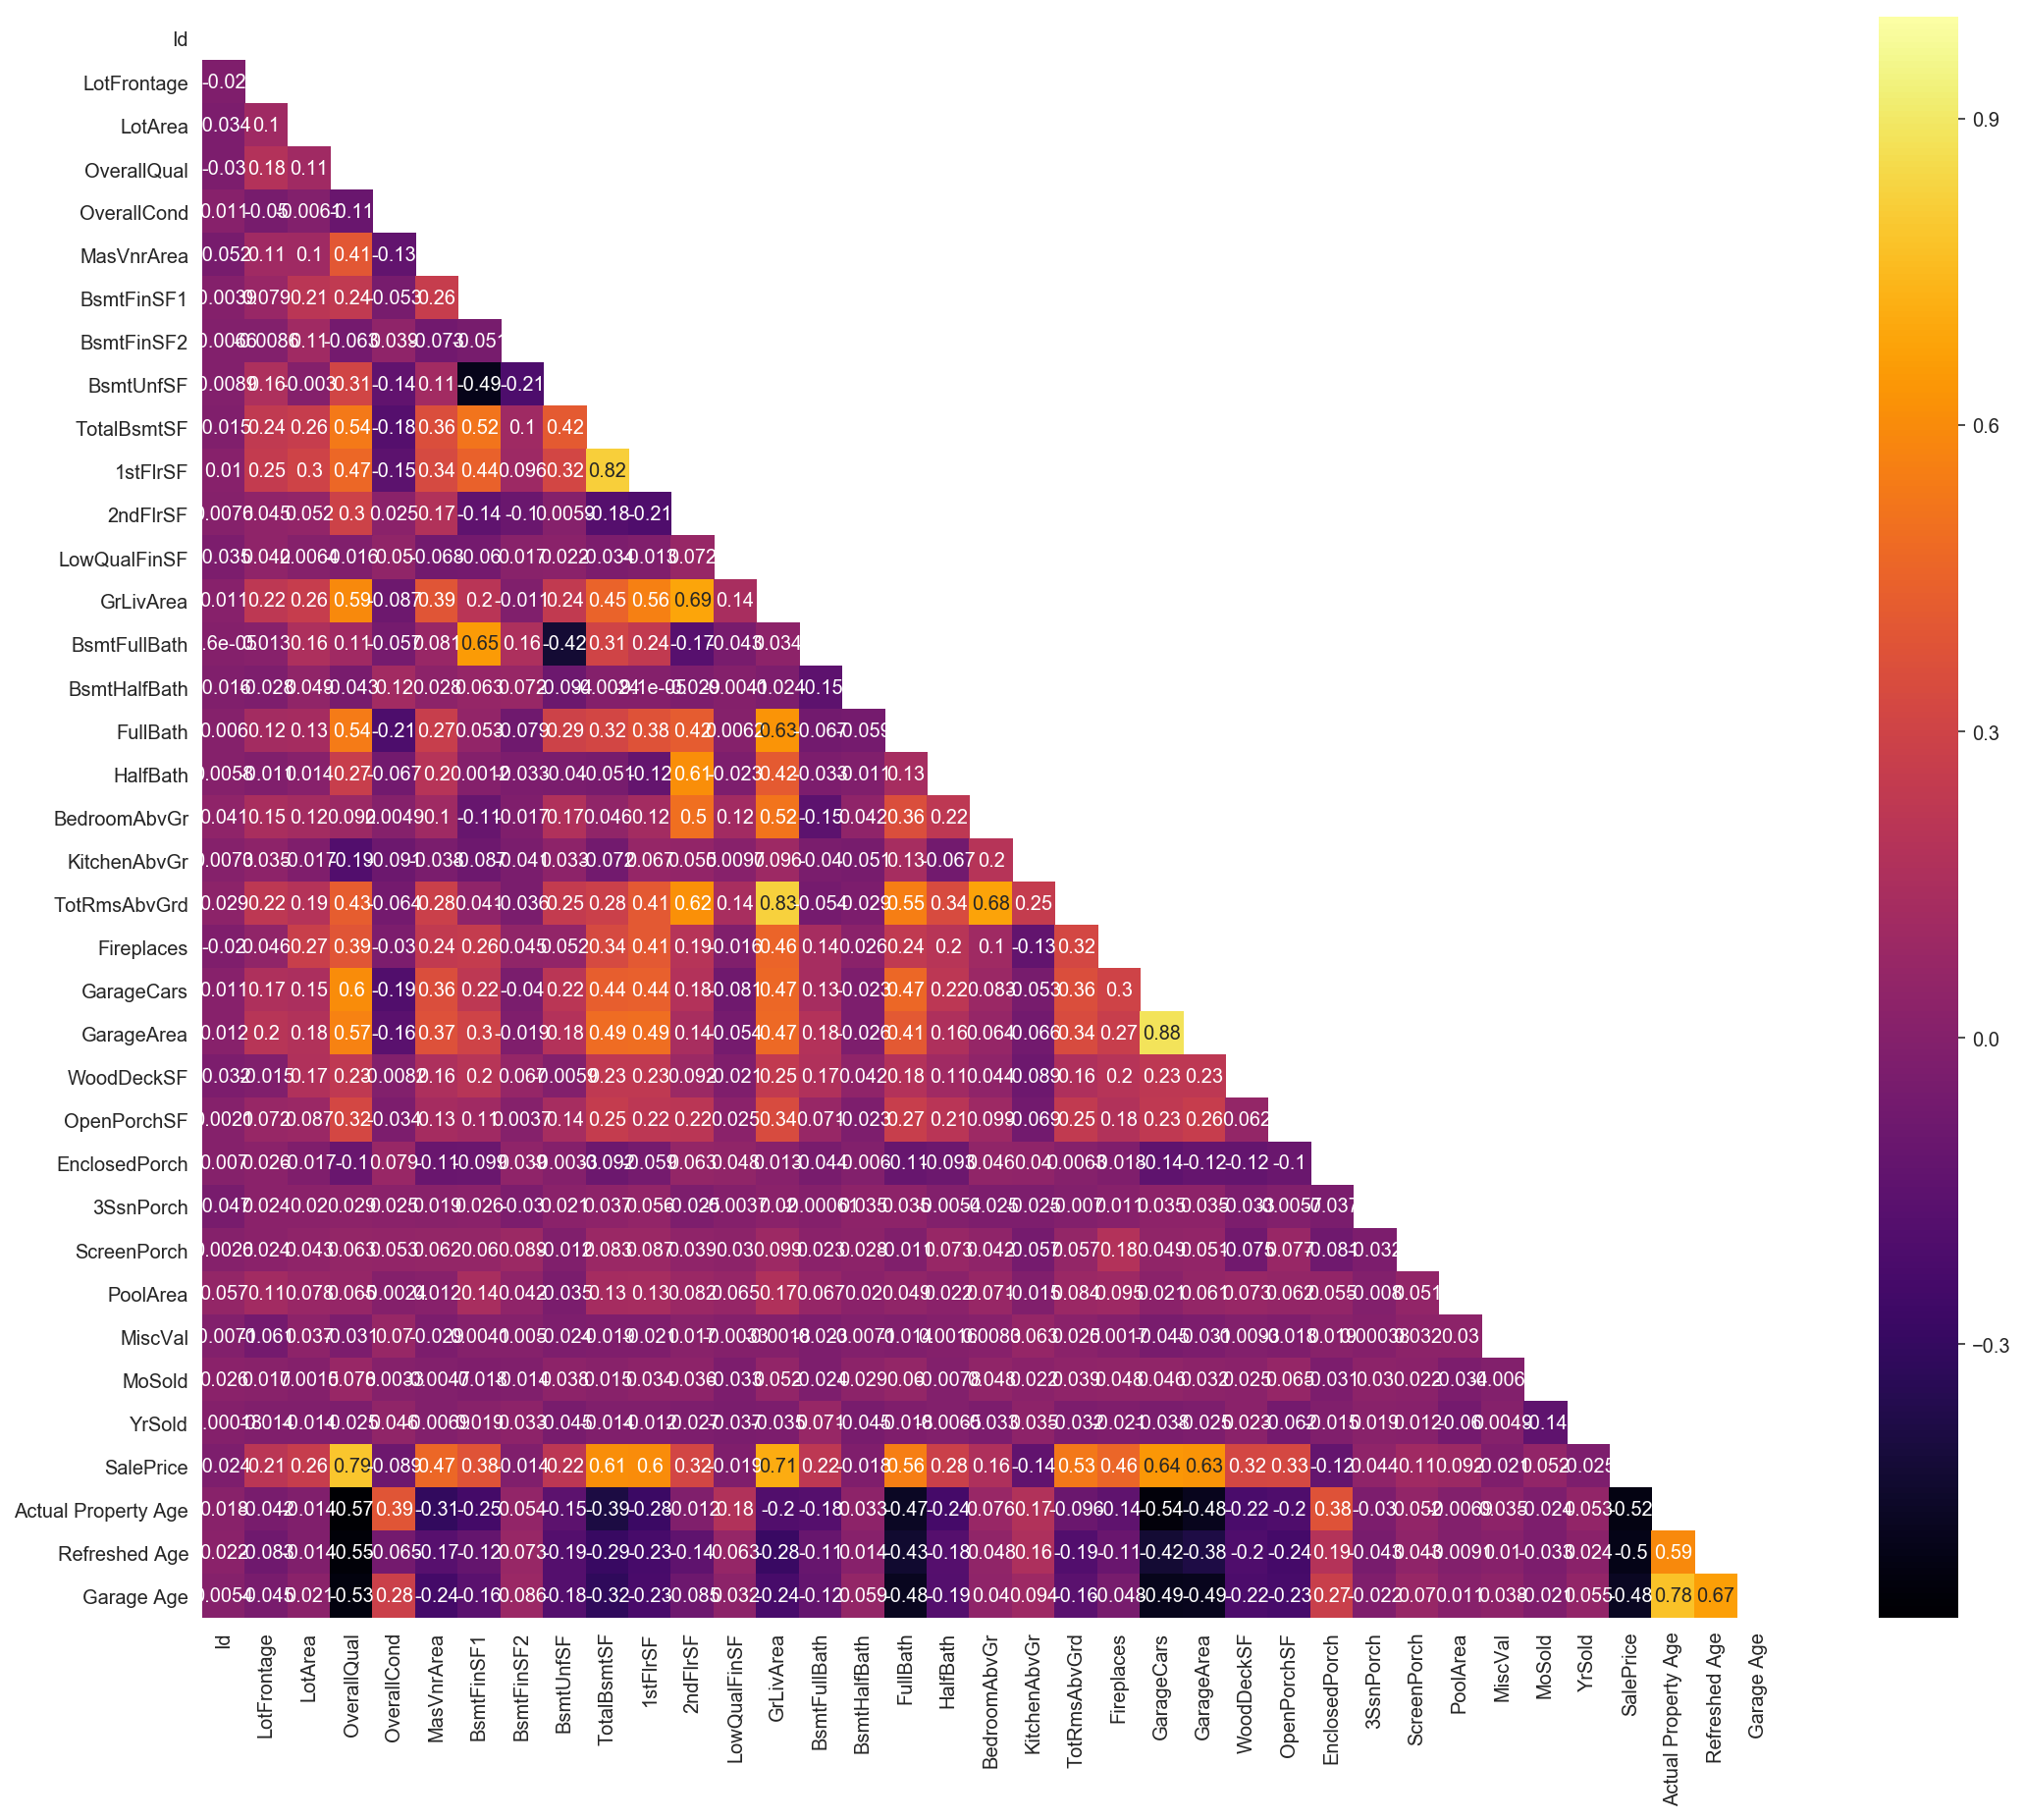

In [54]:
plt.figure(figsize=(18,15))
mask = np.zeros_like(house.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(house.corr(),mask=mask,cmap='inferno',annot=True,);

### PREPROCESSING: Combining fixed dataset and splitting into test and train sets

- Combine to form full fixed dataset
- getdummy to the dataset : it will drop master column and 1 variable each
- split by YrSold to get test and train dataset [1]
- perform SS only on numeric columns from both dataset : outcome is array of std-ized test train x & y
- Dataframe the arrays
- Concatenate back to [1] after dropping same columns by name + YrSold




#### Splitting FIrst

In [55]:
len(fixedcharlist + transact)

45

In [56]:
fixed_df = house[fixedcharlist+transact]
fixed_df.shape

(1450, 45)

In [57]:
fixed_df.YrSold.value_counts()

2009    336
2007    328
2006    312
2008    302
2010    172
Name: YrSold, dtype: int64

In [58]:
fixed_df_dummy = pd.get_dummies(fixed_df,drop_first=True)

In [59]:
fixed_df_train = fixed_df_dummy[fixed_df_dummy['YrSold']!= 2010]

In [60]:
fixed_df_train.reset_index()
fixed_df_train.shape
fixed_df_train.head(5)

,LotFrontage,LotArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,856,856,854,1710,1,0,2,1,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,1262,1262,0,1262,0,1,2,0,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,920,920,866,1786,1,0,2,1,...,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,756,961,756,1717,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,1145,1145,1053,2198,1,0,2,1,...,0,0,0,0,1,0,0,0,1,0


In [61]:
fixed_df_test = fixed_df_dummy[fixed_df_dummy['YrSold']==2010]

In [62]:
fixed_df_test.reset_index()
fixed_df_test.shape

(172, 148)

#### Applying Feature Scaling to X dataset
- only scale the numerical & nondummyvariable columns

In [63]:
# listing out the numeric columns in fixed_df
fixed_numeric = ['LotFrontage','LotArea','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','PoolArea','YrSold','MiscVal','Actual Property Age','Refreshed Age','Garage Age']

In [64]:
# defining test and train sets and test and train targets
fixed_x_train = fixed_df_train[fixed_numeric]
fixed_y_train = fixed_df_train['SalePrice']
fixed_x_test = fixed_df_test[fixed_numeric]
fixed_y_test = fixed_df_test['SalePrice']

In [65]:
ss = StandardScaler()
fixed_xs_train = ss.fit_transform(fixed_x_train)
fixed_xs_test = ss.transform(fixed_x_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [66]:
# Reforming the dataframe after scaling
fixed_xs_train = pd.DataFrame(fixed_xs_train, columns=fixed_numeric, index=fixed_x_train.index)
fixed_xs_test = pd.DataFrame(fixed_xs_test, columns=fixed_numeric, index=fixed_x_test.index)

print(fixed_xs_test.shape)
print(fixed_xs_train.shape)

(172, 22)
(1278, 22)


In [67]:
fixed_df_train.drop(fixed_numeric,axis=1,inplace=True)
fixed_df_train.drop('SalePrice',axis=1,inplace=True)
fixed_df_train.shape

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(1278, 125)

In [68]:
fixed_xs_train_dummied =pd.concat([fixed_df_train,fixed_xs_train],axis=1)
fixed_xs_train_dummied.shape
# This will be my Xs-train

(1278, 147)

In [69]:
fixed_df_test.drop(fixed_numeric,axis=1,inplace=True)
fixed_df_test.drop('SalePrice',axis=1,inplace=True)
fixed_df_test.shape

(172, 125)

In [70]:
fixed_xs_test_dummied =pd.concat([fixed_df_test,fixed_xs_test],axis=1)
fixed_xs_test_dummied.shape
# This will be my Xs-test

(172, 147)

In [71]:
# Redefining

X_train = fixed_xs_train_dummied
X_test = fixed_xs_test_dummied
y_train = fixed_y_train
y_test = fixed_y_test

## Modelling

In [72]:
def coef_df(X_df, model):
    # dictionary with variables and their coefficients
    coef_dict = {'variable':X_df.columns, 'coef':model.coef_}
    
    # convert to df
    coef_df = pd.DataFrame(coef_dict)

    # make coefficients absolute values and sort in descending order
    coef_df['abs_coef'] = abs(coef_df['coef'])
    coef_df.sort_values(by='abs_coef', ascending=False, inplace=True)
    
    return coef_df

### Simple Linear Regression Model
Trying with a simple linear regression

In [73]:
def linear_reg(X_train, y_train, X_test, y_test, results=False, features=None):
    
    # name - this is only useful for comparing our models at the end
    name = 'Linear Regression Model ({})'.format(str(features) + ' features')
    
    # split and fit model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    
    # number of coefficients
    coefs = len(lin_reg.coef_)
    
    # make predictions
    y_pred = lin_reg.predict(X_test)
    
    # calculate Root Mean Squared Error
    rsme = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    
    # calculate R2
    r2_train = lin_reg.score(X_train, y_train)
    r2_test = lin_reg.score(X_test, y_test)
    
    # cross_val score
    cv_score = cross_val_score(lin_reg, X_train, y_train, cv=10)
    
    # print details if results==True
    if results == True:
        print(name)
        print('No. of coefs:', coefs)
        print('RMSE:', rsme)
        print('R^2 train:', r2_train)
        print('R^2 test:', r2_test)
        print('CV R^2 mean:', np.mean(cv_score))
        print('CV R^2 std', np.std(cv_score))
    
    return name, lin_reg, np.mean(cv_score)

In [74]:
linear_reg_norm = linear_reg(X_train, y_train, X_test, y_test, results=True, features=147)
linear_reg_norm

Linear Regression Model (147 features)
No. of coefs: 147
RMSE: 29617.201847119122
R^2 train: 0.8665395750615822
R^2 test: 0.8620224039497904
CV R^2 mean: -6.228873089635333e+22
CV R^2 std 1.8553392968189986e+23


('Linear Regression Model (147 features)',
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 -6.228873089635333e+22)

In [75]:
coef_df(X_train, linear_reg_norm[1]).head(10)

,variable,coef,abs_coef
13,MSSubClass_Class_90,-1.311977e+18,1.311977e+18
73,BldgType_Duplex,1.311977e+18,1.311977e+18
68,Condition2_PosN,-1.453673e+05,1.453673e+05
108,MiscFeature_Gar2,-1.281453e+05,1.281453e+05
67,Condition2_PosA,1.030971e+05,1.030971e+05
113,SaleType_Con,7.123119e+04,7.123119e+04
47,Neighborhood_NoRidge,5.930431e+04,5.930431e+04
100,Functional_Sev,-5.037446e+04,5.037446e+04
54,Neighborhood_StoneBr,4.888439e+04,4.888439e+04
111,MiscFeature_TenC,-4.420792e+04,4.420792e+04


Linear Regression of all features produced result with very close R2 train test scores.  
However, the CV R2 Mean is terrible.  
By its calculations, having a duplex unit would skew your property price by -86million. Baffling.


### Ridge Regression Model

In [76]:
def ridge_reg(X_train, y_train,X_test, y_test, results=False, features=None):
    
    # name - this is only useful for comparing our models at the end
    name = 'Ridge Regression Model ({})'.format(str(features) + ' features')
    
    # create an array of alpha values
    alpha_range = np.logspace(0, 5, 100)
    
    ridge_reg = RidgeCV(alphas=alpha_range, scoring='r2')
    ridge_reg.fit(X_train, y_train)

    # examine the coefficients
    coefs = len(ridge_reg.coef_)

    # best alpha
    best_alpha = ridge_reg.alpha_
    
    # predict uses the best alpha value
    y_pred = ridge_reg.predict(X_test)
    
    # calculate rsme
    rsme = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    # calculate R2
    r2_train = ridge_reg.score(X_train, y_train)
    r2_test = ridge_reg.score(X_test, y_test)

    # cross_val score
    cv_score = cross_val_score(ridge_reg, X_train, y_train, cv=10)
    
    # print details if results==True
    if results == True:
        print(name)
        print('No. of coefs:', coefs)
        print('Best alpha:', best_alpha)
        print('RMSE:', rsme)
        print('R^2 train:', r2_train)
        print('R^2 test:', r2_test)
        print('CV R^2 mean:', np.mean(cv_score))
        print('CV R^2 std', np.std(cv_score))
    
    return name, ridge_reg, np.mean(cv_score)

In [77]:
ridge_reg_norm = ridge_reg(X_train, y_train,X_test, y_test, results=True, features=147)
ridge_reg_norm

Ridge Regression Model (147 features)
No. of coefs: 147
Best alpha: 3.1992671377973836
RMSE: 27546.697885425252
R^2 train: 0.8659257867223195
R^2 test: 0.8806397785961594
CV R^2 mean: 0.812120727780201
CV R^2 std 0.09255954367410867


('Ridge Regression Model (147 features)',
 RidgeCV(alphas=array([1.00000e+00, 1.12332e+00, ..., 8.90215e+04, 1.00000e+05]),
     cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
     scoring='r2', store_cv_values=False),
 0.812120727780201)

In [78]:
coef_df(X_train, ridge_reg_norm[1]).head(10)

,variable,coef,abs_coef
47,Neighborhood_NoRidge,49332.315496,49332.315496
68,Condition2_PosN,-47215.038295,47215.038295
54,Neighborhood_StoneBr,47133.631256,47133.631256
48,Neighborhood_NridgHt,41196.842674,41196.842674
89,BsmtQual_Gd,-35947.410992,35947.410992
91,BsmtQual_TA,-32001.589501,32001.589501
88,BsmtQual_Fa,-28008.144716,28008.144716
21,LotShape_IR3,-26250.210554,26250.210554
39,Neighborhood_Edwards,-22161.610242,22161.610242
101,Functional_Typ,22095.773821,22095.773821


In [79]:
coef_df(X_train, ridge_reg_norm[1]).shape

(147, 3)

- Ridge Regression produced a respectable CV R2 Mean of 0.81, with std dev of 0.09, decent but noticeable variance.  
- The coefficients seem to tell us that the Neighbourhood plays a huge role in determination of the property pricing.  - Surprisingly, being near a positive offsite feature like parks, brings the prices down significantly.
- Basement also seem to negatively impact the prices.   
Intriguing!


### Lasso Regression Model

In [80]:

def lasso_reg(X_train, y_train,X_test, y_test, results=False, features=None):
    
    # name - this is only useful for comparing our models at the end
    name = 'Lasso Regression Model ({})'.format(str(features) + ' features')
    
    
    lasso_reg = LassoCV(n_alphas=200, max_iter=1000000, tol=0.001, random_state=1, cv=5)
    lasso_reg.fit(X_train, y_train)
    
    # examine the coefficients
    coefs = len(lasso_reg.coef_)

    # best alpha
    best_alpha = lasso_reg.alpha_

    # predict uses the best alpha value
    y_pred = lasso_reg.predict(X_test)
    
    # calculate rsme
    rsme = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    # calculate R2
    r2_train = lasso_reg.score(X_train, y_train)
    r2_test = lasso_reg.score(X_test, y_test)

    # cross_val score
    cv_score = cross_val_score(lasso_reg, X_train, y_train, cv=10)
    
    # print details if results==True
    if results == True:
        print(name)
        print('No. of coefs:', coefs)
        print('Best alpha:',  best_alpha)
        print('RSME:', rsme)
        print('R^2 train:', r2_train)
        print('R^2 test:', r2_test)
        print('CV R^2 mean:', np.mean(cv_score))
        print('CV R^2 std', np.std(cv_score))
    
    return name, lasso_reg, np.mean(cv_score)



In [81]:
lasso_reg_norm = lasso_reg(X_train, y_train,X_test, y_test, results=True, features=147)
lasso_reg_norm

Lasso Regression Model (147 features)
No. of coefs: 147
Best alpha: 188.70373732716328
RSME: 28061.567937773314
R^2 train: 0.8510920745007184
R^2 test: 0.8761362024834881
CV R^2 mean: 0.8182239183251113
CV R^2 std 0.10220090299964837


('Lasso Regression Model (147 features)',
 LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
     max_iter=1000000, n_alphas=200, n_jobs=None, normalize=False,
     positive=False, precompute='auto', random_state=1, selection='cyclic',
     tol=0.001, verbose=False),
 0.8182239183251113)

In [82]:
coef_df(X_train, lasso_reg_norm[1]).head(10)

,variable,coef,abs_coef
47,Neighborhood_NoRidge,54713.966023,54713.966023
54,Neighborhood_StoneBr,49171.651028,49171.651028
48,Neighborhood_NridgHt,44289.554948,44289.554948
89,BsmtQual_Gd,-28566.310849,28566.310849
91,BsmtQual_TA,-23743.858199,23743.858199
130,GrLivArea,20262.913056,20262.913056
101,Functional_Typ,20033.960450,20033.960450
38,Neighborhood_Crawfor,19587.509862,19587.509862
92,BsmtExposure_Gd,17795.061646,17795.061646
95,BsmtExposure_No Bsmt Expo,-17139.430420,17139.430420


In [83]:
lassodrop = coef_df(X_train, lasso_reg_norm[1])[coef_df(X_train, lasso_reg_norm[1])['coef']==0]
lassodrop.shape

(88, 3)

- Lasso produced a CV R2 Mean of 0.81, with a slightly worse std dev of 0.1.  
- Lasso confirmed that the Neighbourhood plays a huge role in price impact, with the top 3 coefficients being neighbourhood variables
- 88 coefficients have been dropped by lasso

### Elastic Net Regression 

In [84]:
def elast_net_reg(X_train, y_train, X_test, y_test, results=False, features=None):
    
    # name - this is only useful for comparing our models at the end
    name = 'Elastic Net Regression Model ({})'.format(str(features) + ' features')

    elast_net = ElasticNetCV(n_alphas=100, l1_ratio=np.linspace(0.01,1,20), max_iter=1000000, random_state=1, cv=5)
    elast_net.fit(X_train, y_train)
    
    # examine the coefficients
    coefs = len(elast_net.coef_)

    # best alpha & l1 ratio
    best_alpha = elast_net.alpha_
    best_l1 = elast_net.l1_ratio_

    # predict uses the best alpha value
    y_pred = elast_net.predict(X_test)
    
    # calculate rsme
    rsme = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    # calculate R2
    r2_train = elast_net.score(X_train, y_train)
    r2_test = elast_net.score(X_test, y_test)

    # cross_val score
    cv_score = cross_val_score(elast_net, X_train, y_train, cv=10)
    
    # print details if results==True
    if results == True:
        print(name)
        print('No. of coefs:', coefs)
        print('Best alpha:',  best_alpha)
        print('Best l1 ratio:', best_l1)        
        print('RSME:', rsme)
        print('R^2 train:', r2_train)
        print('R^2 test:', r2_test)
        print('CV R^2 mean:', np.mean(cv_score))
        print('CV R^2 std', np.std(cv_score))
    
    return name, elast_net, np.mean(cv_score)



In [85]:
elast_net_reg_norm = elast_net_reg(X_train, y_train,X_test, y_test, results=True, features=147)
elast_net_reg_norm

Elastic Net Regression Model (147 features)
No. of coefs: 147
Best alpha: 196.60604011727642
Best l1 ratio: 1.0
RSME: 28125.446445104106
R^2 train: 0.8499315311506493
R^2 test: 0.8755716410091406
CV R^2 mean: 0.81865080749712
CV R^2 std 0.10224821865558159


('Elastic Net Regression Model (147 features)',
 ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        l1_ratio=array([0.01   , 0.06211, 0.11421, 0.16632, 0.21842, 0.27053, 0.32263,
        0.37474, 0.42684, 0.47895, 0.53105, 0.58316, 0.63526, 0.68737,
        0.73947, 0.79158, 0.84368, 0.89579, 0.94789, 1.     ]),
        max_iter=1000000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=1,
        selection='cyclic', tol=0.0001, verbose=0),
 0.81865080749712)

In [86]:
coef_df(X_train, elast_net_reg_norm[1]).head(10)

,variable,coef,abs_coef
47,Neighborhood_NoRidge,54564.720836,54564.720836
54,Neighborhood_StoneBr,48799.143543,48799.143543
48,Neighborhood_NridgHt,44175.972833,44175.972833
89,BsmtQual_Gd,-28039.637783,28039.637783
130,GrLivArea,26072.351363,26072.351363
91,BsmtQual_TA,-23161.815294,23161.815294
101,Functional_Typ,19984.560292,19984.560292
38,Neighborhood_Crawfor,19515.659830,19515.659830
92,BsmtExposure_Gd,17773.316042,17773.316042
53,Neighborhood_Somerst,16532.620306,16532.620306


In [87]:
models = [linear_reg_norm,  
          ridge_reg_norm, 
          lasso_reg_norm, 
          elast_net_reg_norm]

for i in models:
    print(i[0])
    print('CV R^2 mean:', i[2])
    print('------------------')

Linear Regression Model (147 features)
CV R^2 mean: -6.228873089635333e+22
------------------
Ridge Regression Model (147 features)
CV R^2 mean: 0.812120727780201
------------------
Lasso Regression Model (147 features)
CV R^2 mean: 0.8182239183251113
------------------
Elastic Net Regression Model (147 features)
CV R^2 mean: 0.81865080749712
------------------


### Try removing variables dropped by lasso and running again.
- Drop 88 features from X_train and X_test
- run new X_train & X_test

In [88]:
droplasso = list(lassodrop.variable.values)
len(droplasso)
droplasso

['SaleCondition_Family',
 'Functional_Maj2',
 'PoolArea',
 'Functional_Min2',
 'Functional_Min1',
 'MiscVal',
 'SaleType_ConLw',
 'Functional_Sev',
 'SaleType_Oth',
 'BsmtExposure_Mn',
 'SaleType_WD',
 'BsmtQual_No Basement',
 'Functional_Mod',
 'GarageArea',
 'SaleType_ConLD',
 'GarageType_Attchd',
 'GarageType_Basment',
 'GarageType_BuiltIn',
 'GarageType_CarPort',
 'GarageType_Detchd',
 'SaleCondition_AdjLand',
 'MiscFeature_Gar2',
 'MiscFeature_Othr',
 'MiscFeature_Shed',
 'MiscFeature_TenC',
 'SaleType_CWD',
 'SaleCondition_Partial',
 'SaleType_ConLI',
 'SaleType_Con',
 'SaleCondition_Alloca',
 'BldgType_Duplex',
 'Foundation_Wood',
 'Neighborhood_MeadowV',
 'Neighborhood_CollgCr',
 'Neighborhood_ClearCr',
 'Neighborhood_BrDale',
 'Neighborhood_Blueste',
 'LandSlope_Sev',
 'LandSlope_Mod',
 'LotConfig_Inside',
 'LotConfig_FR3',
 'Utilities_NoSeWa',
 'LandContour_Low',
 'Alley_Pave',
 'Street_Pave',
 'MSZoning_RL',
 'MSZoning_RH',
 'MSSubClass_Class_90',
 'MSSubClass_Class_85',
 'M

In [89]:
X_train_lasso = X_train.drop(droplasso,axis=1)
X_train_lasso.shape

(1278, 59)

In [90]:
X_test_lasso = X_test.drop(droplasso,axis=1)
X_test_lasso.shape

(172, 59)

In [91]:
linear_reg_droplasso = linear_reg(X_train_lasso, y_train, X_test_lasso, y_test, results=True, features = 59)
linear_reg_droplasso

Linear Regression Model (59 features)
No. of coefs: 59
RMSE: 27958.133898949665
R^2 train: 0.863003928912612
R^2 test: 0.8770476355902543
CV R^2 mean: 0.8100622232158358
CV R^2 std 0.09109372739320482


('Linear Regression Model (59 features)',
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 0.8100622232158358)

In [92]:
ridge_reg_droplasso = ridge_reg(X_train_lasso, y_train, X_test_lasso, y_test, results=True, features = 59)
ridge_reg_droplasso

Ridge Regression Model (59 features)
No. of coefs: 59
Best alpha: 2.0092330025650473
RMSE: 27749.33134624637
R^2 train: 0.8611529209414178
R^2 test: 0.87887729277566
CV R^2 mean: 0.8254583799106623
CV R^2 std 0.08518583676861553


('Ridge Regression Model (59 features)',
 RidgeCV(alphas=array([1.00000e+00, 1.12332e+00, ..., 8.90215e+04, 1.00000e+05]),
     cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
     scoring='r2', store_cv_values=False),
 0.8254583799106623)

In [93]:
lasso_reg_droplasso = lasso_reg(X_train_lasso, y_train, X_test_lasso, y_test, results=True, features = 59)
lasso_reg_droplasso

Lasso Regression Model (59 features)
No. of coefs: 59
Best alpha: 158.63668179283596
RSME: 27941.759483388258
R^2 train: 0.8546085322059943
R^2 test: 0.8771916139797445
CV R^2 mean: 0.8167912658682688
CV R^2 std 0.09854278445581417


('Lasso Regression Model (59 features)',
 LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
     max_iter=1000000, n_alphas=200, n_jobs=None, normalize=False,
     positive=False, precompute='auto', random_state=1, selection='cyclic',
     tol=0.001, verbose=False),
 0.8167912658682688)

In [94]:
elast_net_reg_droplasso = elast_net_reg(X_train_lasso, y_train, X_test_lasso, y_test, results=True, features = 59)
elast_net_reg_droplasso

Elastic Net Regression Model (59 features)
No. of coefs: 59
Best alpha: 159.473220658597
Best l1 ratio: 1.0
RSME: 27978.659424544225
R^2 train: 0.854332012693975
R^2 test: 0.8768670378230571
CV R^2 mean: 0.8166962546288655
CV R^2 std 0.09851705229703393


('Elastic Net Regression Model (59 features)',
 ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        l1_ratio=array([0.01   , 0.06211, 0.11421, 0.16632, 0.21842, 0.27053, 0.32263,
        0.37474, 0.42684, 0.47895, 0.53105, 0.58316, 0.63526, 0.68737,
        0.73947, 0.79158, 0.84368, 0.89579, 0.94789, 1.     ]),
        max_iter=1000000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=1,
        selection='cyclic', tol=0.0001, verbose=0),
 0.8166962546288655)

In [95]:
models = [linear_reg_norm,
          linear_reg_droplasso,
          ridge_reg_norm,
          ridge_reg_droplasso,
          lasso_reg_norm,
          lasso_reg_droplasso,
          elast_net_reg_norm,
          elast_net_reg_droplasso]

for i in models:
    print(i[0])
    print('CV R^2 mean:', i[2])
    print('------------------')

Linear Regression Model (147 features)
CV R^2 mean: -6.228873089635333e+22
------------------
Linear Regression Model (59 features)
CV R^2 mean: 0.8100622232158358
------------------
Ridge Regression Model (147 features)
CV R^2 mean: 0.812120727780201
------------------
Ridge Regression Model (59 features)
CV R^2 mean: 0.8254583799106623
------------------
Lasso Regression Model (147 features)
CV R^2 mean: 0.8182239183251113
------------------
Lasso Regression Model (59 features)
CV R^2 mean: 0.8167912658682688
------------------
Elastic Net Regression Model (147 features)
CV R^2 mean: 0.81865080749712
------------------
Elastic Net Regression Model (59 features)
CV R^2 mean: 0.8166962546288655
------------------


##### Essentially, the removing of 88 feature variables have drastically improved the linear regression model, but the other models have largely remained similar  
#### Below show the top coefficients of the second round of modelling


In [96]:
coef_df(X_train_lasso, ridge_reg_droplasso[1]).head(10)

,variable,coef,abs_coef
25,Condition2_PosN,-67015.290176,67015.290176
17,Neighborhood_NoRidge,58790.469414,58790.469414
21,Neighborhood_StoneBr,54759.629905,54759.629905
18,Neighborhood_NridgHt,45549.225181,45549.225181
36,BsmtExposure_No Bsmt Expo,-39523.589558,39523.589558
32,BsmtQual_Gd,-37316.166301,37316.166301
33,BsmtQual_TA,-33646.448684,33646.448684
31,BsmtQual_Fa,-32677.079163,32677.079163
5,LotShape_IR3,-26337.717932,26337.717932
22,Neighborhood_Veenker,24056.214926,24056.214926


In [97]:
coef_df(X_train_lasso, elast_net_reg_droplasso[1]).head(10)

,variable,coef,abs_coef
17,Neighborhood_NoRidge,56399.509257,56399.509257
21,Neighborhood_StoneBr,51171.968069,51171.968069
18,Neighborhood_NridgHt,44932.459813,44932.459813
25,Condition2_PosN,-31112.920192,31112.920192
32,BsmtQual_Gd,-30610.749236,30610.749236
33,BsmtQual_TA,-26310.935628,26310.935628
46,GrLivArea,25533.668445,25533.668445
36,BsmtExposure_No Bsmt Expo,-22214.467817,22214.467817
12,Neighborhood_Crawfor,20802.117824,20802.117824
31,BsmtQual_Fa,-20434.520920,20434.520920


In [98]:
coef_df(X_train_lasso, elast_net_reg_droplasso[1])[coef_df(X_train_lasso, elast_net_reg_droplasso[1])['abs_coef']==0]

,variable,coef,abs_coef
6,LotShape_Reg,-0.0,0.0


#### Try visualizing the ridge regression for 59 features

In [99]:
alpha_range = np.logspace(0,5,100)
ridge_reg_vis = RidgeCV(alphas=alpha_range,scoring='r2')
ridge_reg_vis.fit(X_train_lasso,y_train)
y_pred = ridge_reg_vis.predict(X_test_lasso)
rsme = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
r2_train = ridge_reg_vis.score(X_train_lasso,y_train)
r2_test = ridge_reg_vis.score(X_test_lasso,y_test)
cv_score = cross_val_score(ridge_reg_vis, X_train_lasso,y_train,cv=10)

In [100]:
cv_score

array([0.89296416, 0.86927245, 0.87322043, 0.75852564, 0.86255597,
       0.8294396 , 0.89140133, 0.84038631, 0.59502783, 0.84179008])

In [101]:
plotdf = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


''

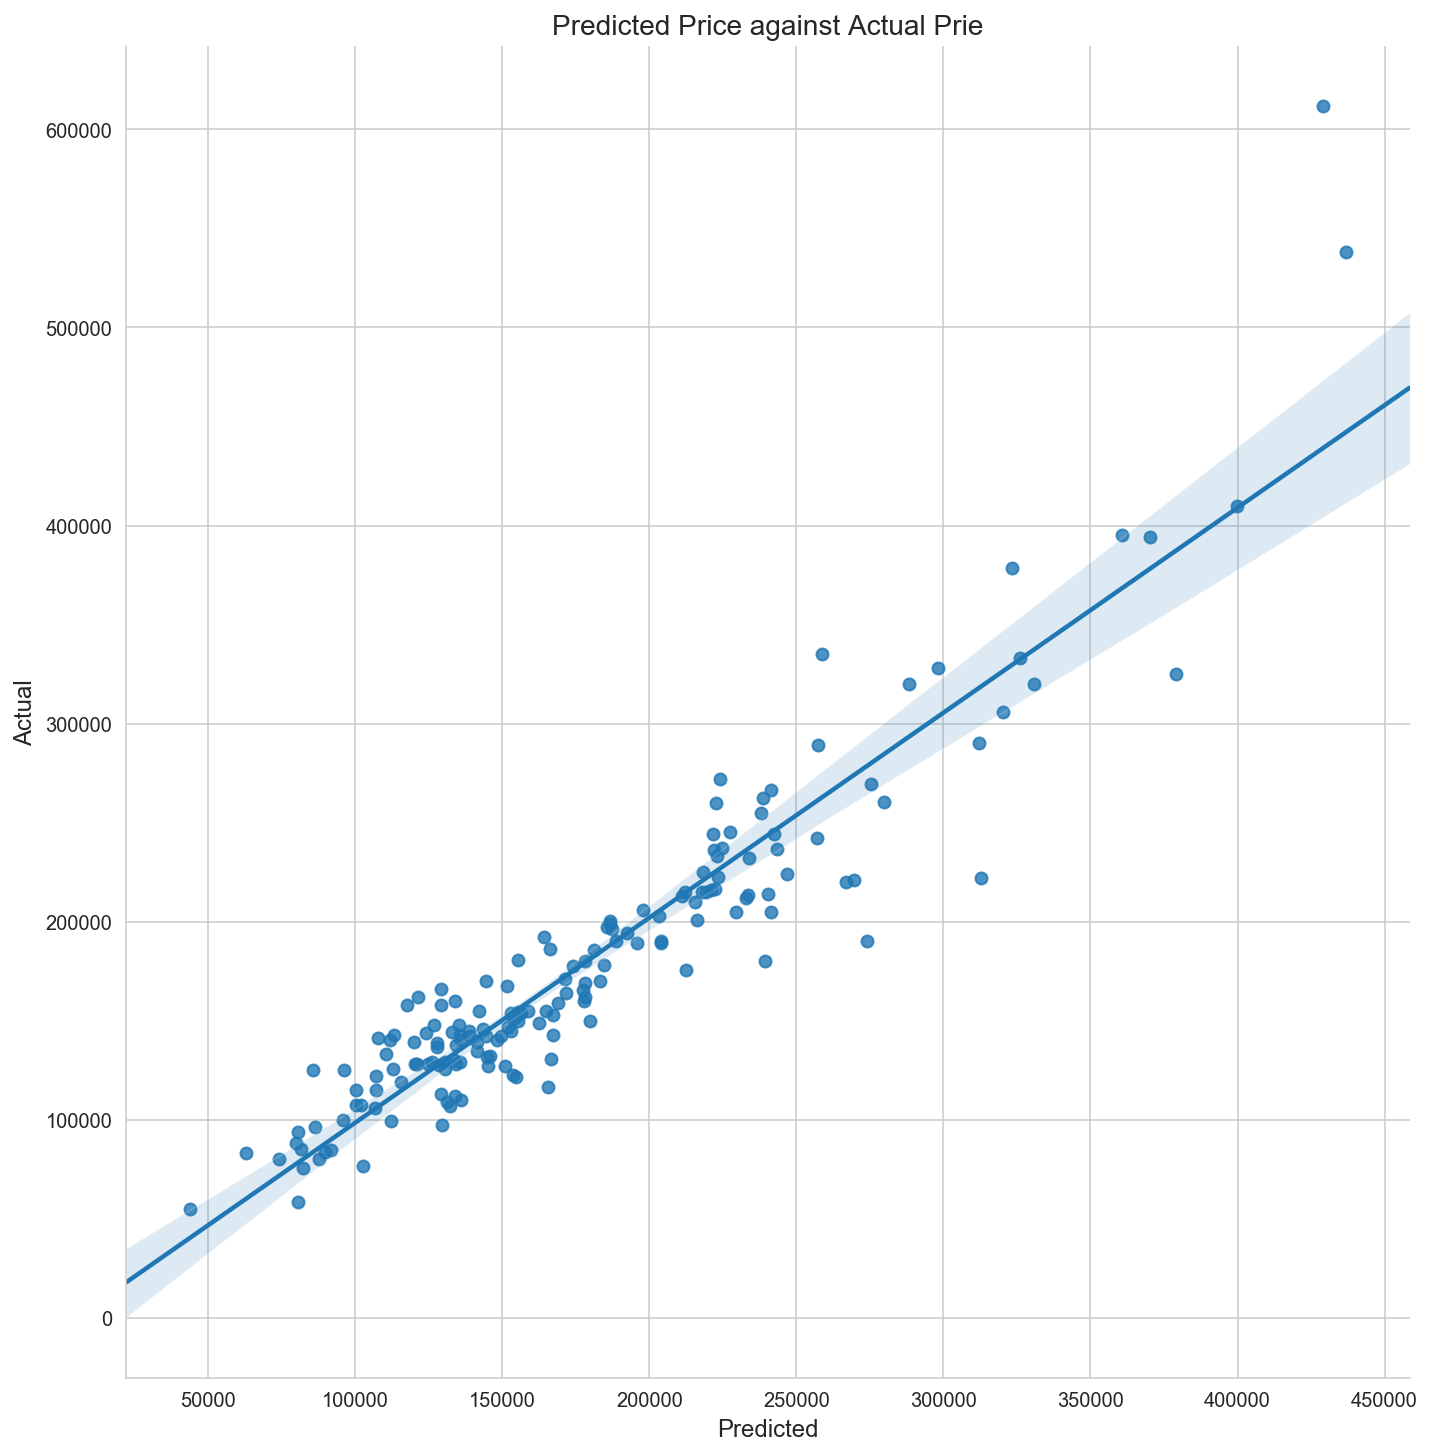

In [102]:

sns.lmplot('y_pred','y_test',data=plotdf,height=10)
plt.title('Predicted Price against Actual Prie',fontsize=14)
plt.xlabel('Predicted',fontsize=12)
plt.ylabel('Actual',fontsize=12)
;


In [103]:
residuals = y_test - y_pred

''

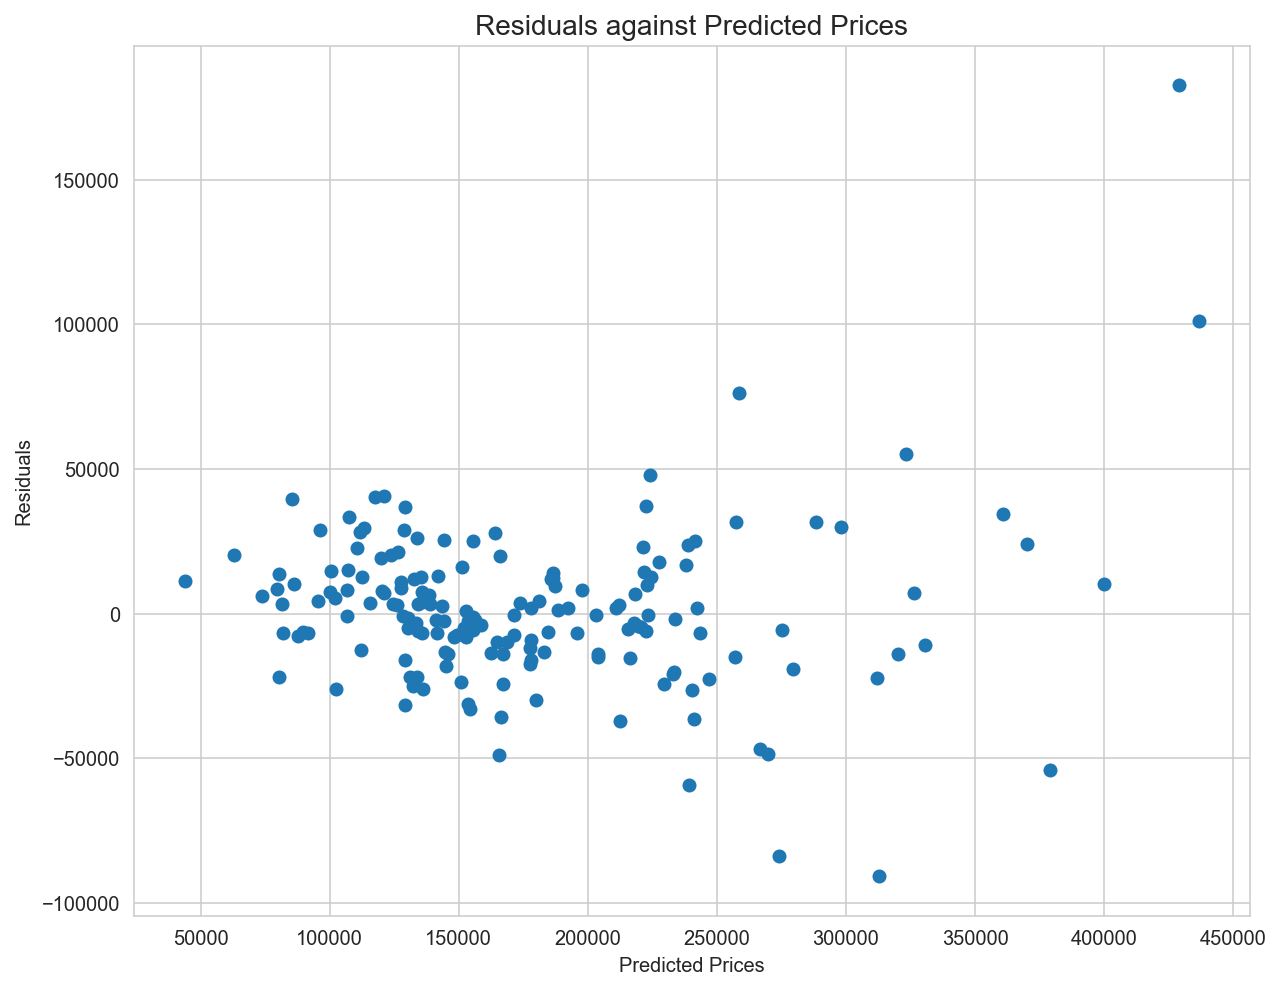

In [104]:
plt.figure(figsize=(10,8))
plt.scatter(y_pred,residuals)

plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals against Predicted Prices', fontsize=14)
;

In [105]:
residuals.shape

(172,)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?



## 2. Approach
- Using our model, we have a predicted pricing for 2010 houses
- We have to use the residuals as a target of renovation features modelling
- Hence we need to create residual column to work to reno_df ..which is the list of renovatable columns + YrSold
- 




In [106]:
renocharlist.append('YrSold')

In [107]:
len(renocharlist)

35

In [108]:
reno_df = house[renocharlist]

In [109]:
reno_df.shape

(1450, 35)

In [110]:
reno_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 35 columns):
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-null object
Exterior2nd      1450 non-null object
MasVnrType       1450 non-null object
MasVnrArea       1450 non-null float64
ExterQual        1450 non-null object
ExterCond        1450 non-null object
Fence            1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
BsmtCond         1450 non-null object
BsmtFinType1     1450 non-null object
BsmtFinSF1       1450 non-null int64
BsmtFinType2     1450 non-null object
BsmtFinSF2       1450 non-null int64
BsmtUnfSF        1450 non-null int64
Heating          1450 non-null object
HeatingQC        1450 non-null object
CentralAir       1450 non-null object
Electrical       1450 non-null object
LowQualFinSF     1450 non-null int64
FireplaceQu      1450 non-null object
KitchenQual      1450 no

In [122]:
# numeric fields for re-joining after scaling
reno_numeric=['MasVnrArea','OverallQual','OverallCond','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','LowQualFinSF','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','YrSold']
len(reno_numeric)

13

In [112]:
# dummy step
reno_df_dummy = pd.get_dummies(reno_df,drop_first=True)

In [113]:
reno_df_dummy.shape

(1450, 124)

In [114]:
# split-resetting
reno_df_train = reno_df_dummy[reno_df_dummy['YrSold']!= 2010]
reno_df_train.reset_index()
reno_df_train.shape

(1278, 124)

In [115]:
reno_df_test = reno_df_dummy[reno_df_dummy['YrSold']== 2010]
reno_df_test.reset_index()
reno_df_test.shape

(172, 124)

In [116]:
# working out the residual
fix = fixed_df_dummy[fixed_df_dummy['YrSold']!= 2010]
fix.reset_index()
fix.shape

(1278, 148)

In [117]:
# Defining for scaling
reno_x_train = reno_df_train[reno_numeric]
reno_x_test = reno_df_test[reno_numeric]

# Target variables are residuals
reno_y_train = fix['SalePrice'] - ridge_reg_vis.predict(X_train_lasso)
reno_y_test = residuals

#### Applying Scaling

In [120]:
ss = StandardScaler()
reno_xs_train = ss.fit_transform(reno_x_train)
reno_xs_test = ss.transform(reno_x_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [121]:
# Reforming the dataframe after scaling
reno_xs_train = pd.DataFrame(reno_xs_train, columns=reno_numeric, index=reno_x_train.index)
reno_xs_test = pd.DataFrame(reno_xs_test, columns=reno_numeric, index=reno_x_test.index)

print(reno_xs_test.shape)
print(reno_xs_train.shape)

(172, 13)
(1278, 13)


In [123]:
# Dropping numeric columns and concat scaled df
reno_df_train.drop(reno_numeric,axis=1,inplace=True)
reno_df_train.shape


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(1278, 111)

In [124]:
reno_xs_train_dummied =pd.concat([reno_df_train,reno_xs_train],axis=1)
reno_xs_train_dummied.shape
# This will be my Xs-train

(1278, 124)

In [125]:
reno_df_test.drop(reno_numeric,axis=1,inplace=True)
reno_df_test.shape

(172, 111)

In [126]:
reno_xs_test_dummied =pd.concat([reno_df_test,reno_xs_test],axis=1)
reno_xs_test_dummied.shape
# This will be my Xs-test

(172, 124)

In [127]:
# Defining for models
X_train2 = reno_xs_train_dummied
X_test2 = reno_xs_test_dummied
y_train2 = reno_y_train
y_test2 = reno_y_test

### Modelling 
#### Simple Linear Reg

In [128]:
linear_reg_norm2 = linear_reg(X_train2, y_train2, X_test2, y_test2, results=True, features=124)
linear_reg_norm2

Linear Regression Model (124 features)
No. of coefs: 124
RMSE: 4.0280254270620664e+16
R^2 train: 0.3465072642991198
R^2 test: -2.1113987303282645e+24
CV R^2 mean: -4.354146001808102e+24
CV R^2 std 1.0635843197795469e+25


('Linear Regression Model (124 features)',
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 -4.354146001808102e+24)

#### Horrendous. Go to lasso to try and find features for culling

In [129]:
lasso_reg_norm2 = lasso_reg(X_train2, y_train2,X_test2, y_test2, results=True, features=124)
lasso_reg_norm2

Lasso Regression Model (124 features)
No. of coefs: 124
Best alpha: 149.53812317333268
RSME: 26352.16759294618
R^2 train: 0.16584690956798553
R^2 test: 0.09631195507446964
CV R^2 mean: 0.006264871392558269
CV R^2 std 0.08536585634764758


('Lasso Regression Model (124 features)',
 LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
     max_iter=1000000, n_alphas=200, n_jobs=None, normalize=False,
     positive=False, precompute='auto', random_state=1, selection='cyclic',
     tol=0.001, verbose=False),
 0.006264871392558269)

In [130]:
coef_df(X_train2, lasso_reg_norm2[1]).head(10)

,variable,coef,abs_coef
11,RoofMatl_WdShngl,41060.684518,41060.684518
14,Exterior1st_BrkFace,14176.990752,14176.990752
91,KitchenQual_Gd,-12005.787183,12005.787183
109,PoolQC_Gd,-9250.332824,9250.332824
112,OverallQual,7628.674073,7628.674073
64,BsmtFinType1_Unf,-7188.830668,7188.830668
92,KitchenQual_TA,-6351.436737,6351.436737
40,Exterior2nd_Wd Shng,-5532.761410,5532.761410
114,BsmtFinSF1,-4607.126716,4607.126716
87,FireplaceQu_No Fire Qual,4584.719589,4584.719589


In [132]:
lassodrop2 = coef_df(X_train2, lasso_reg_norm2[1])[coef_df(X_train2, lasso_reg_norm2[1])['coef']==0]
lassodrop2.shape

(85, 3)

In [136]:
droplasso2 = list(lassodrop2.variable.values)
len(droplasso2)
# droplasso2

85

In [137]:
X_train_lasso2 = X_train2.drop(droplasso2,axis=1)
X_train_lasso2.shape

(1278, 39)

In [138]:
X_test_lasso2 = X_test2.drop(droplasso2,axis=1)
X_test_lasso2.shape

(172, 39)

- We just used lasso to identify 85 features for dropping and will rerun the models

In [139]:
linear_reg_droplasso2 = linear_reg(X_train_lasso2, y_train2, X_test_lasso2, y_test2, results=True, features = 39)
linear_reg_droplasso2

Linear Regression Model (39 features)
No. of coefs: 39
RMSE: 26461.191724609656
R^2 train: 0.19670034736547237
R^2 test: 0.08881901467164766
CV R^2 mean: -0.031982104350539706
CV R^2 std 0.19199738244842018


('Linear Regression Model (39 features)',
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 -0.031982104350539706)

In [140]:
ridge_reg_droplasso2 = ridge_reg(X_train_lasso2, y_train2, X_test_lasso2, y_test2, results=True, features = 39)
ridge_reg_droplasso2

Ridge Regression Model (39 features)
No. of coefs: 39
Best alpha: 1.0
RMSE: 26495.708367905332
R^2 train: 0.19512441802650593
R^2 test: 0.08644032953502345
CV R^2 mean: 0.008727611064753957
CV R^2 std 0.12258361772951665


('Ridge Regression Model (39 features)',
 RidgeCV(alphas=array([1.00000e+00, 1.12332e+00, ..., 8.90215e+04, 1.00000e+05]),
     cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
     scoring='r2', store_cv_values=False),
 0.008727611064753957)

In [141]:
lasso_reg_droplasso2 = lasso_reg(X_train_lasso2, y_train2, X_test_lasso2, y_test2, results=True, features = 39)
lasso_reg_droplasso2

Lasso Regression Model (39 features)
No. of coefs: 39
Best alpha: 80.05623132232942
RSME: 26358.037046486457
R^2 train: 0.18785560471061413
R^2 test: 0.0959093509488963
CV R^2 mean: 0.0005111930535087073
CV R^2 std 0.1216252478138914


('Lasso Regression Model (39 features)',
 LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
     max_iter=1000000, n_alphas=200, n_jobs=None, normalize=False,
     positive=False, precompute='auto', random_state=1, selection='cyclic',
     tol=0.001, verbose=False),
 0.0005111930535087073)

In [143]:
elast_net_reg_droplasso2 = elast_net_reg(X_train_lasso2, y_train2, X_test_lasso2, y_test2, results=True, features = 39)
elast_net_reg_droplasso2

Elastic Net Regression Model (39 features)
No. of coefs: 39
Best alpha: 78.44460900779652
Best l1 ratio: 1.0
RSME: 26360.43208695374
R^2 train: 0.18820369772390255
R^2 test: 0.0957450418947744
CV R^2 mean: -0.0029262805370663834
CV R^2 std 0.11565688969102743


('Elastic Net Regression Model (39 features)',
 ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        l1_ratio=array([0.01   , 0.06211, 0.11421, 0.16632, 0.21842, 0.27053, 0.32263,
        0.37474, 0.42684, 0.47895, 0.53105, 0.58316, 0.63526, 0.68737,
        0.73947, 0.79158, 0.84368, 0.89579, 0.94789, 1.     ]),
        max_iter=1000000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=1,
        selection='cyclic', tol=0.0001, verbose=0),
 -0.0029262805370663834)

In [144]:
coef_df(X_train_lasso2, ridge_reg_droplasso2[1]).head(10)

,variable,coef,abs_coef
2,RoofMatl_WdShngl,62712.513055,62712.513055
27,PoolQC_Gd,-52676.239551,52676.239551
7,Exterior2nd_ImStucc,21141.657805,21141.657805
3,Exterior1st_BrkFace,18547.371559,18547.371559
22,KitchenQual_Gd,-14948.448579,14948.448579
25,GarageQual_Fa,-11961.955627,11961.955627
9,Exterior2nd_Wd Shng,-11952.351476,11952.351476
16,BsmtFinType1_Unf,-9235.250633,9235.250633
23,KitchenQual_TA,-9063.605600,9063.605600
28,OverallQual,7814.014735,7814.014735


### Breaking it all down (before i do)

- Models reflect terrible scores
- After culling, ridge gave the best score of the pack
- We take a look at the coefficients from ridge

#### Coeff 
- Roof Material of Woodshingles add 62k to the value of the house
- Ironically, the presence of a good quality pool reduces the value by 52k
- Ditto for a good quality kitchen @ 15k reduction
- Exterior materials round up the top 5 by adding up to 39k

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [118]:
# A: